In [1]:
import sys
sys.path.append("../..")

# Noisy Pendulum - Iterated Extended Kalman Filter and Smoother Examples

Estimate pendulum state with IEKF and IERTS as in Examples 7.11 and 13.6 of the book

_Simo Särkkä and Lennart Svensson (2023), Bayesian Filtering and Smoothing, 2nd ed., Cambridge University Press._

See LICENSE provided with the software.

## Imports

### Standard imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg, stats
import tqdm

### Helpers imports

In [3]:
from python.common_utilities import generate_pendulum, RandomState, rmse, plot_pendulum

## Routine

Set the parameters:

In [4]:
dt = 0.01
g  = 9.81

In [5]:
Q  = 0.01 * np.array([[dt ** 3 / 3, dt ** 2 / 2], 
                      [dt ** 2 / 2, dt]])
R  = 0.1 * np.eye(1)

In [6]:
x_0 = np.array([1.5, 0.])

## Simulate data

In [7]:
random_state = RandomState(1)
steps = 500

timeline, states, observations = generate_pendulum(x_0, g, Q, dt, R, steps, random_state)

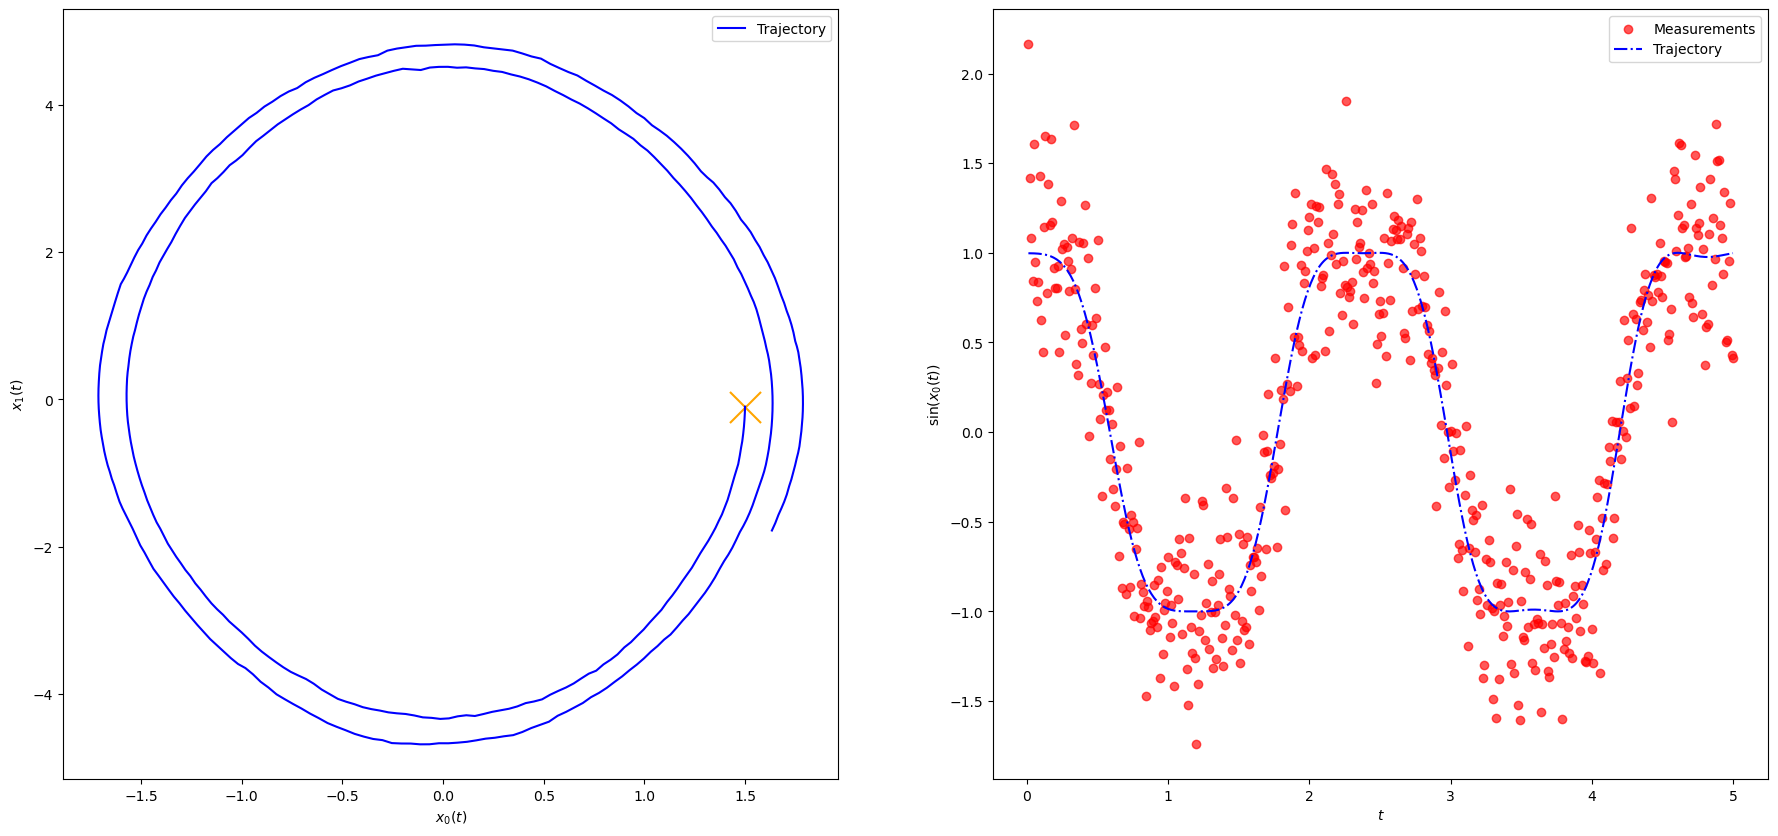

In [8]:
plot_pendulum(timeline, observations, states, "Trajectory")

## Iterated Extended Kalman Filter

In [9]:
m_0 = np.array([1.6, 0.])  # Slightly off
P_0 = np.array([[0.1, 0.], 
                [0., 0.1]])

In [10]:
def iterated_extended_kalman_filter(m_0, P_0, g, Q, dt, R, observations, niter=10):
    n = m_0.shape[-1]
    steps = observations.shape[0]
    
    iekf_m = np.empty((steps, n))
    iekf_P = np.empty((steps, n, n))
    
    m = m_0[:]
    P = P_0[:]
    
    for i in range(steps):
        y = observations[i]
        
        # Jacobian of the dynamic model function
        F = np.array([[1., dt], 
                      [-g * dt * np.cos(m[0]), 1.]])
        
        # Predicted state distribution
        mp = np.array([m[0] + dt * m[1],
                      m[1] - g * dt * np.sin(m[0])])
        Pp = F @ P @ F.T + Q
        
        m = mp
        P = Pp
        for iter in range(niter):
            # Linearization at current m
            h = np.sin(m[0])
            H = np.array([[np.cos(m[0]), 0.]])
            
            # Affine Kalman filter update
            v = y - h - H.dot(mp - m)
            S = H.dot(Pp.dot(H.T)) + R
            K = linalg.solve(S, H @ Pp, assume_a="pos").T 
            m = mp + K @ np.atleast_1d(v)
            P = Pp - K @ S @ K.T
        
        iekf_m[i] = m
        iekf_P[i] = P
    return iekf_m, iekf_P

In [11]:
iekf_m, iekf_P = iterated_extended_kalman_filter(m_0, P_0, g, Q, dt, R, observations)

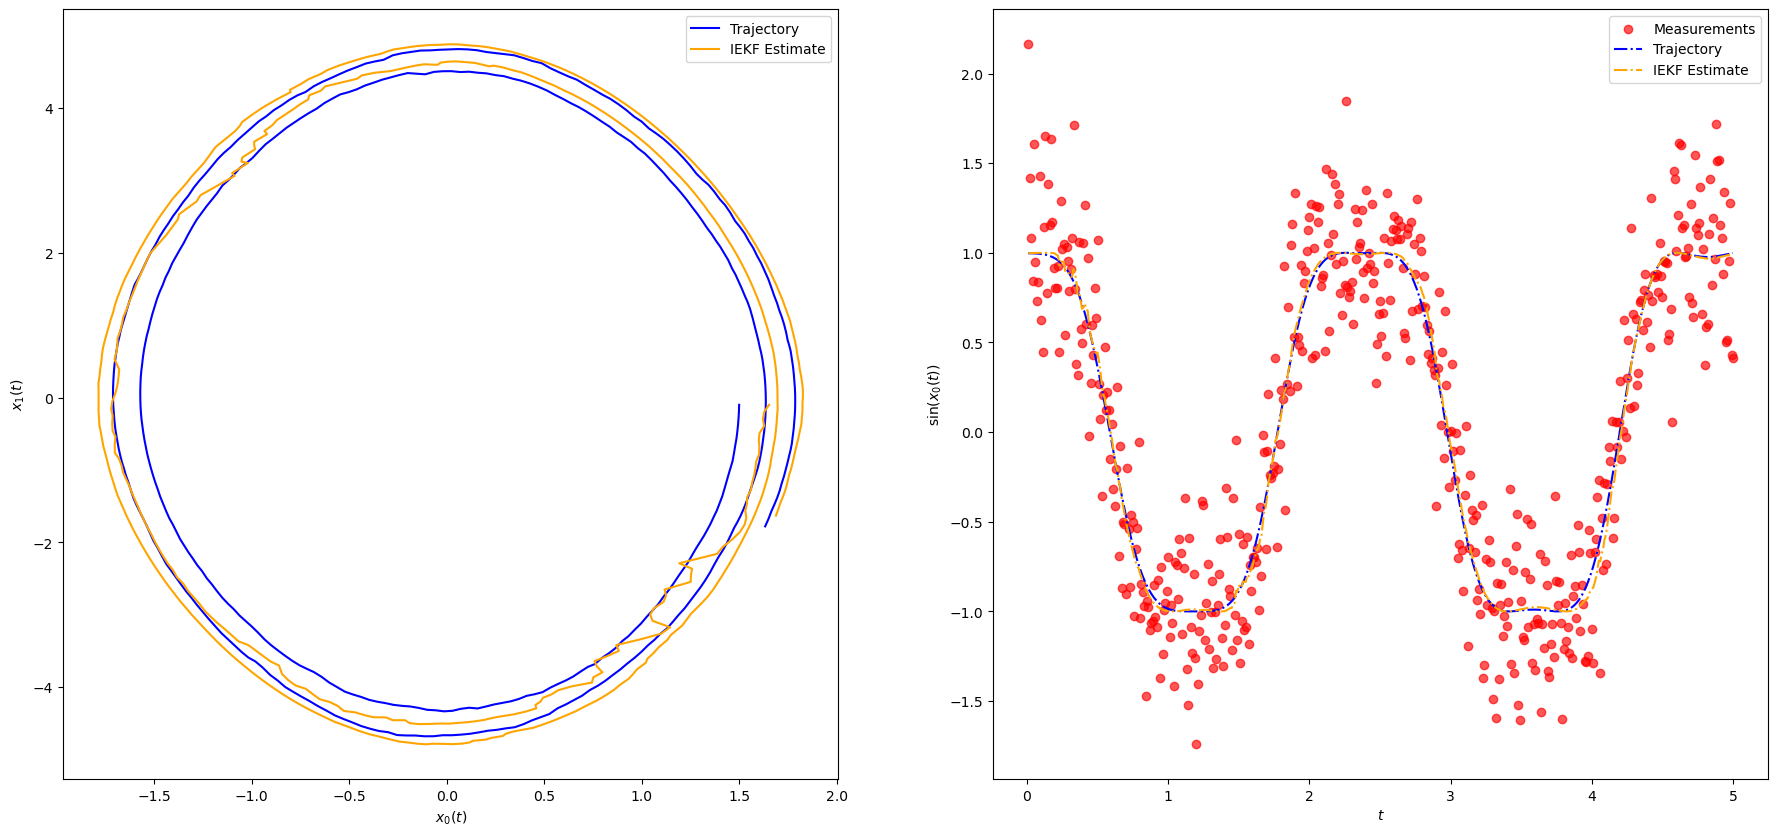

In [12]:
plot_pendulum(timeline, observations, states, "Trajectory", iekf_m, "IEKF Estimate")

In [13]:
rmse_iekf = rmse(iekf_m[:, :1], states[:, :1])
print(f"IEKF RMSE: {rmse_iekf}")

IEKF RMSE: 0.08117957962290018


## Iterated Extended RTS

In [14]:
def iterated_extended_smoother(init_m, init_P, m_0, P_0, g, Q, dt, R, observations, niter=10):    
    n = m_0.shape[-1]
    steps = observations.shape[0]
    
    ekf_m = np.empty((steps, n))
    ekf_P = np.empty((steps, n, n))

    irts_m = np.empty((steps, n))
    irts_P = np.empty((steps, n, n))
    
    nom_m = np.copy(init_m)
    nom_m_0 = m_0

    for iter in range(niter):
        m = m_0
        P = P_0

        # Run EKF
        for i in range(steps):
            if i == 0:
                nm = nom_m_0
            else:
                nm = nom_m[i-1]
            
            # Jacobian of the dynamic model function
            F = np.array([[1., dt], 
                          [-g * dt * np.cos(nm[0]), 1.]])
        
            # Predicted state distribution
            m = np.array([nm[0] + dt * nm[1],
                          nm[1] - g * dt * np.sin(nm[0])]) + F @ (m - nm)
            P = F @ P @ F.T + Q
        
            nm = nom_m[i]
        
            # Predicted observation
            H = np.array([[np.cos(nm[0]), 0.]])
            h = np.sin(nm[0]) + H.dot(m - nm)
            S = H.dot(P.dot(H.T)) + R
        
            y = observations[i]        
            K = linalg.solve(S, H @ P, assume_a="pos").T 
            m = m + K @ np.atleast_1d(y - h)
            P = P - K @ S @ K.T
        
            ekf_m[i] = m
            ekf_P[i] = P
            
        # Run smoother
        ms = ekf_m[-1]
        Ps = ekf_P[-1]
    
        irts_m[-1] = ms
        irts_P[-1] = Ps
        nom_m[-1] = ms
    
        for i in range(steps-2, -2, -1):
            if i == -1:
                filtered_m = m_0
                filtered_P = P_0
                nm = nom_m_0
            else:
                filtered_m = ekf_m[i]
                filtered_P = ekf_P[i]
                nm = nom_m[i]
        
            F = np.array([[1., dt], 
                          [-g * dt * np.cos(nm[0]), 1.]])
        
            mp = np.array([nm[0] + dt * nm[1], 
                           nm[1] - g * dt * np.sin(nm[0])]) + F @ (filtered_m - nm)
            Pp = F @ filtered_P @ F.T + Q
        
            Gk = linalg.solve(Pp, F @ filtered_P, assume_a="pos").T 

            ms = filtered_m + Gk @ (ms - mp)
            Ps = filtered_P + Gk @ (Ps - Pp) @ Gk.T
        
            if i == -1:
                nom_m_0 = ms
            else:
                irts_m[i] = ms
                irts_P[i] = Ps
                nom_m[i] = ms

    return irts_m, irts_P


In [15]:
irts_m, irts_P = iterated_extended_smoother(iekf_m, iekf_P, m_0, P_0, g, Q, dt, R, observations)

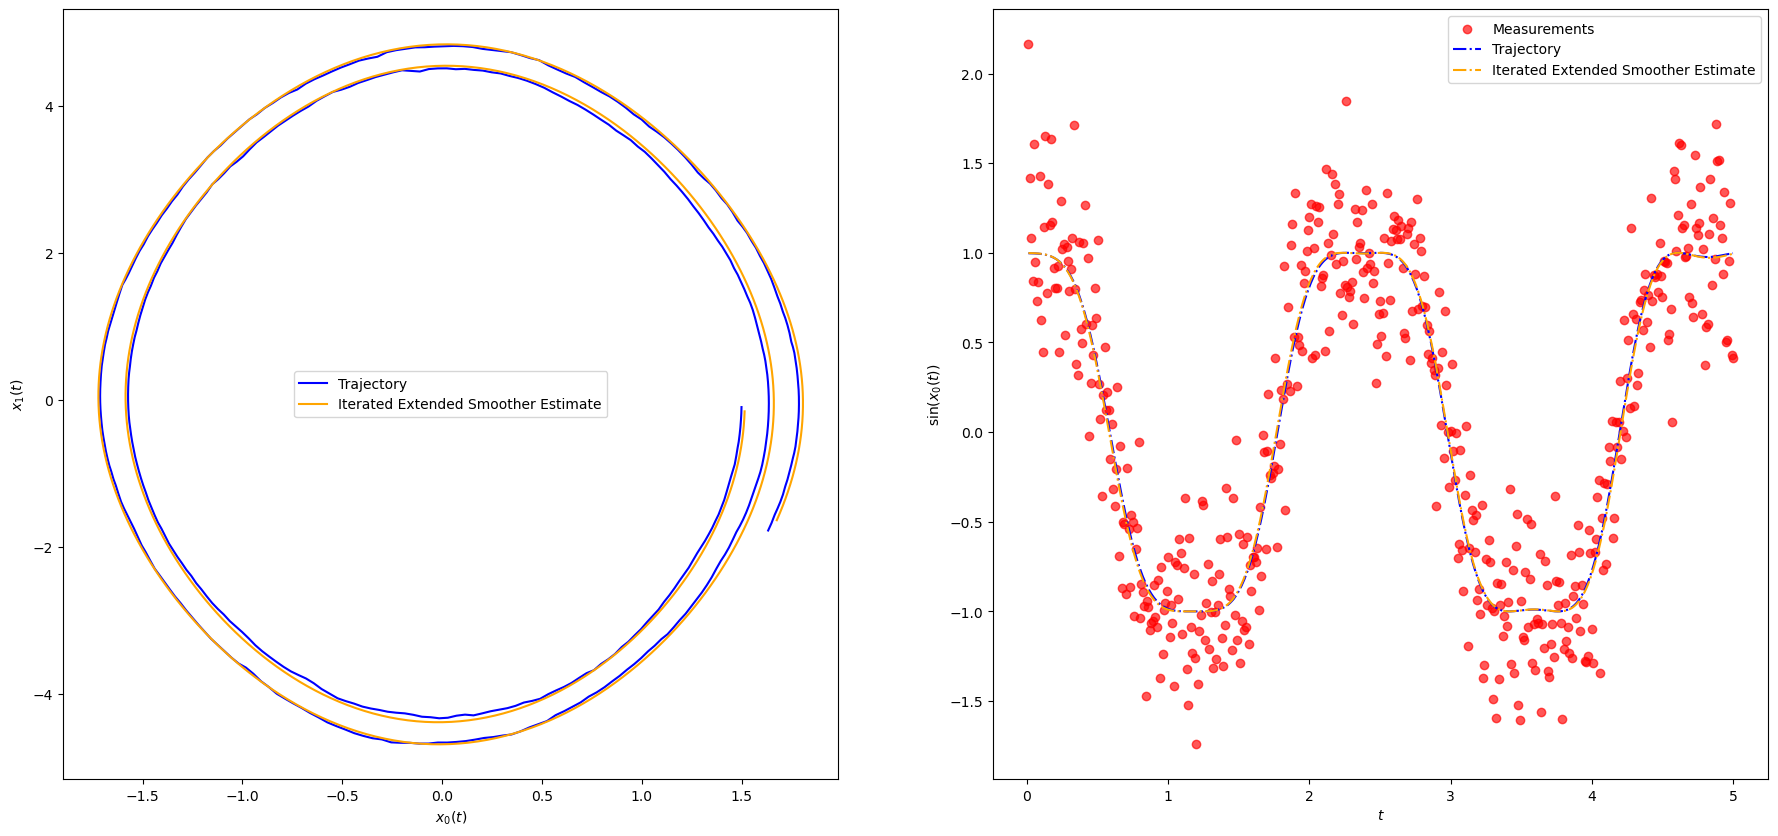

In [16]:
plot_pendulum(timeline, observations, states, "Trajectory", irts_m, "Iterated Extended Smoother Estimate")

In [17]:
rmse_ierts = rmse(irts_m[:, :1], states[:, :1])
print(f"IERTS RMSE: {rmse_ierts}")

IERTS RMSE: 0.022089892140616574
